# 0. Install packages

In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn deap pygraphviz

# 1. Imports and Constants

In [1]:
import pandas as pd
import numpy as np
import kagglehub

RANDOM_STATE = 42

# 2. Dataset loading and inspection

## 2.0 Load Dataset

In [2]:
from kagglehub import KaggleDatasetAdapter

original_df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "joebeachcapital/differentiated-thyroid-cancer-recurrence",
    "Thyroid_Diff.csv",
)

## 2.1 DataFrame Overview

### 2.1.0 Shape

In [3]:
original_df.shape

(383, 17)

### 2.1.1 Columns

In [4]:
original_df.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

### 2.1.2 First 5 rows (head)

In [5]:
original_df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


### 2.1.3 Data Types (dtypes)

In [6]:
original_df.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

# 3. Preprocessing

## 3.0 Clean up

In [7]:
X = pd.DataFrame()
y = pd.DataFrame()

cleaned_df = original_df.dropna()
print(f"cleaned: {cleaned_df.shape} vs original: {original_df.shape}")

cleaned: (383, 17) vs original: (383, 17)


## 3.1 Numerical features (Standard normalization a.k.a z-score) 

In [8]:
from sklearn.preprocessing import StandardScaler

numerical_features_names = ["Age"]

standard_scaler = StandardScaler()
X[numerical_features_names] = standard_scaler.fit_transform(
    cleaned_df[numerical_features_names]
)

## 3.2 Categorical Features

### 3.2.0 Nominal Categorical Features (One-Hot encoding)

In [9]:
from sklearn.preprocessing import OneHotEncoder

nominal_features_names = [
    "Gender",
    "Smoking",
    "Thyroid Function",
    "Physical Examination",
    "Adenopathy",
    "Pathology",
    "Focality",
    "Risk",
    "T",
    "N",
    "M",
]

onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
onehot_features = onehot_encoder.fit_transform(cleaned_df[nominal_features_names])
onehot_features_names = onehot_encoder.get_feature_names_out(nominal_features_names)
onehot_df = pd.DataFrame(onehot_features.toarray(), columns=onehot_features_names)

X = pd.concat([X.reset_index(drop=True), onehot_df.reset_index(drop=True)], axis=1)

### 3.2.1 Ordinal Categorical Features (Label encoding)

In [10]:
from sklearn.preprocessing import LabelEncoder

ordinal_features_names = ["Stage", "Response"]

label_encoder = LabelEncoder()
for ofn in ordinal_features_names:
    X[ofn] = label_encoder.fit_transform(cleaned_df[ofn])

### 3.2.2 Binary Categorical Features (Binary encoding)

In [11]:
binary_features_names = ["Hx Smoking", "Hx Radiothreapy"]
for bfn in binary_features_names:
    X[bfn] = cleaned_df[bfn].map({"Yes": 1, "No": 0})

### 3.2.3 Binary Categorical Target (Binary encoding)

In [12]:
target_names = ["Recurred"]
for btn in target_names:
    y[btn] = cleaned_df[btn].map({"Yes": 1, "No": 0})

### 3.2.4 Replacing spaces and dashes with _ in X.columns so preventing error in Arg names

In [13]:
columns = {c: c.replace(" ", "_").replace("-", "_") for c in X.columns}
X = X.rename(columns=columns)

# 4. Modeling

## 4.0 imports

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from functools import partial
import operator
import random
from deap import base, creator, tools, gp
from deap.algorithms import varAnd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## 4.1 Train/Test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

## 4.2 Prepare primitives and primitive set

In [16]:
# Defining a div which wont raise division by zero exception
def div(left, right):
    if right == 0:
        return left
    return left / right


def if_neg(a, b, c):
    if a < 0:
        return b
    return c


def if_pos(a, b, c):
    if a > 0:
        return b
    return c


def if_zero(a, b, c):
    if a != 0:
        return c
    return b


pset = gp.PrimitiveSet("MAIN", len(X.columns))
pset.addPrimitive(if_neg, 3)
pset.addPrimitive(if_pos, 3)
pset.addPrimitive(if_zero, 3)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addEphemeralConstant("normrand", partial(random.normalvariate, 0, 1))

arg_names = {f"ARG{i}": v for i, v in enumerate(X.columns)}
pset.renameArguments(**arg_names)

## 4.3 Creator, Toolbox and Fitness function

In [17]:
random.seed(RANDOM_STATE)

POP_SIZE = 700
GEN_NUM = 150
TOURN_SIZE = 4
XOVER_PROBA = 0.5
MUTAION_PROBA = 0.1
MAX_TREE_DEPTH = 7

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

max_float = np.finfo(float).max
min_float = np.finfo(float).min
divisor = 2.0 * len(X)
cvt_nan = min_float / divisor
cvt_ninf = min_float / divisor
cvt_pinf = max_float / divisor


def fix_problematic_values(v):
    return np.nan_to_num(v, nan=cvt_nan, neginf=cvt_ninf, posinf=cvt_pinf)


def predict(individual, arg_x):
    func = toolbox.compile(expr=individual)
    pred = np.array([func(*x) for x in arg_x])
    pred = fix_problematic_values(pred)
    return pred


def to_proba(values):
    return 1 / (1 + np.exp(-values))


def to_class(proba):
    return (proba > 0.5).astype(int)


def bce(y_true, y_pred_proba):
    # Clip predictions to avoid log(0) or log(1)
    y_pred_proba = np.clip(y_pred_proba.reshape(y_true.shape), 1e-15, 1 - 1e-15)
    # Calculate Binary Cross-Entropy
    return -np.mean(
        y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba)
    )


def fitfunc(individual, arg_x, arg_y):
    pred = predict(individual, arg_x)
    pred_proba = to_proba(pred)
    return (bce(arg_y, pred_proba),)


kwargs = {"arg_x": X_train.to_numpy(), "arg_y": y_train.to_numpy()}
toolbox.register("evaluate", fitfunc, **kwargs)

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("select", tools.selTournament, tournsize=TOURN_SIZE)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)

toolbox.register("mate", gp.cxOnePoint)
toolbox.decorate(
    "mate",
    gp.staticLimit(
        key=operator.attrgetter("height"),
        max_value=MAX_TREE_DEPTH,
    ),
)

toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate(
    "mutate",
    gp.staticLimit(
        key=operator.attrgetter("height"),
        max_value=MAX_TREE_DEPTH,
    ),
)

## 4.4 Finding the best Model

In [18]:
pop = toolbox.population(n=POP_SIZE)

# Initialize lists to store train/test scores history for the best individuals
train_scores = []
train_accuracies = []
test_scores = []
test_accuracies = []
best_individuals = []

# print log headers
header = f"{'gen':^6}|{'neval':^6}|{'fit min':^14}|{'fit max':^14}|{'fit avg':^14}|{'fit std':^14}|{'size min':^10}|{'size max':^10}|{'size avg':^10}|{'size std':^10}"
header_separator = "-" * len(header)
print(header)
print(header_separator)

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

# Evaluate the entire population
fitnesses = [toolbox.evaluate(individual) for individual in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = (fit[0],)  # Assign train score as fitness

for gen in range(GEN_NUM):
    offspring = toolbox.select(pop, POP_SIZE)
    offspring = varAnd(offspring, toolbox, XOVER_PROBA, MUTAION_PROBA)

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    nevals = len(invalid_ind)

    pop[:] = offspring

    fitnesses = [ind.fitness.values for ind in pop]

    best_individual = tools.selBest(pop, k=1)[0]
    best_individuals.append(best_individual)

    train_score = fitfunc(best_individual, X_train_np, y_train_np)[0]
    train_scores.append(train_score)
    train_pred = predict(best_individual, X_train_np)
    train_pred_proba = to_proba(train_pred)
    train_pred_class = to_class(train_pred_proba)
    train_accuracy = accuracy_score(y_train_np, train_pred_class)
    train_accuracies.append(train_accuracy)

    test_score = fitfunc(best_individual, X_test_np, y_test_np)[0]
    test_scores.append(test_score)
    test_pred = predict(best_individual, X_test_np)
    test_pred_proba = to_proba(test_pred)
    test_pred_class = to_class(test_pred_proba)
    test_accuracy = accuracy_score(y_test_np, test_pred_class)
    test_accuracies.append(test_accuracy)

    sizes = [len(ind) for ind in pop]
    fitnesses = [fit[0] for fit in fitnesses]
    fmin = str(f"{min(fitnesses):7.4f}")
    fmax = str(f"{max(fitnesses):7.4f}")
    favg = str(f"{np.average(fitnesses):7.4f}")
    fstd = str(f"{np.std(fitnesses):7.4f}")
    smin = str(f"{min(sizes):4d}")
    smax = str(f"{max(sizes):4d}")
    savg = str(f"{np.average(sizes):5.1f}")
    sstd = str(f"{np.std(sizes):5.1f}")

    print(
        f"{gen:^6}|{nevals:^6}|{fmin:^14}|{fmax:^14}|{favg:^14}|{fstd:^14}|{smin:^10}|{smax:^10}|{savg:^10}|{sstd:^10}"
    )

 gen  |neval |   fit min    |   fit max    |   fit avg    |   fit std    | size min | size max | size avg | size std 
---------------------------------------------------------------------------------------------------------------------
  0   | 374  |    0.4553    |    1.2002    |    0.6812    |    0.0987    |      1   |     20   |    4.5   |    2.5   
  1   | 359  |    0.4393    |    1.5456    |    0.6389    |    0.1188    |      1   |     20   |    4.7   |    2.7   
  2   | 413  |    0.4099    |    1.5839    |    0.5911    |    0.1337    |      1   |     18   |    4.6   |    2.9   
  3   | 410  |    0.3930    |    1.0673    |    0.5444    |    0.1107    |      1   |     22   |    4.9   |    3.1   
  4   | 376  |    0.3724    |    1.3640    |    0.5332    |    0.1310    |      1   |     18   |    5.1   |    2.8   
  5   | 393  |    0.3472    |    1.0755    |    0.5109    |    0.1212    |      1   |     17   |    5.0   |    2.5   
  6   | 370  |    0.3472    |    1.7042    |    0.4990  

/tmp/ipykernel_246572/542169927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-values))


  94  | 367  |    0.1098    |    4.8235    |    0.1557    |    0.2040    |      1   |     59   |   46.6   |    6.4   
  95  | 386  |    0.1098    |    1.0132    |    0.1537    |    0.1080    |      1   |     65   |   47.4   |    7.2   
  96  | 399  |    0.1058    |    1.2927    |    0.1502    |    0.1035    |      1   |     62   |   49.2   |    6.2   
  97  | 401  |    0.1058    |    0.9778    |    0.1505    |    0.1052    |      1   |     83   |   50.0   |    7.1   
  98  | 367  |    0.1058    |    1.4114    |    0.1445    |    0.1058    |      4   |     67   |   51.1   |    5.9   
  99  | 367  |    0.1058    |    0.9204    |    0.1407    |    0.0944    |     11   |     65   |   51.9   |    5.4   
 100  | 420  |    0.1058    |    1.1191    |    0.1499    |    0.1064    |      1   |     66   |   52.7   |    6.5   
 101  | 395  |    0.1054    |    1.5879    |    0.1448    |    0.1137    |      1   |     70   |   53.3   |    6.6   
 102  | 371  |    0.1040    |    1.5879    |    0.1517  

/tmp/ipykernel_246572/542169927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-values))


 114  | 350  |    0.0937    |    2.1374    |    0.1382    |    0.1199    |      1   |     75   |   57.3   |    6.4   
 115  | 424  |    0.0937    |    1.0373    |    0.1373    |    0.0977    |      6   |     72   |   57.3   |    7.0   
 116  | 399  |    0.0937    |    1.5663    |    0.1402    |    0.1153    |      3   |     82   |   58.0   |    7.8   
 117  | 359  |    0.0937    |    0.7315    |    0.1298    |    0.0820    |      3   |     75   |   60.2   |    7.4   
 118  | 371  |    0.0937    |    1.2561    |    0.1321    |    0.1142    |      1   |     79   |   62.6   |    7.6   
 119  | 351  |    0.0937    |    0.9126    |    0.1235    |    0.0843    |      2   |     78   |   65.0   |    7.2   
 120  | 373  |    0.0918    |    1.3420    |    0.1205    |    0.0904    |      1   |     78   |   66.1   |    6.2   
 121  | 378  |    0.0918    |    1.1478    |    0.1234    |    0.0961    |     31   |     82   |   66.4   |    5.5   
 122  | 379  |    0.0916    |   10.2493    |    0.1396  

## 4.5 Train/Test fitness over generations

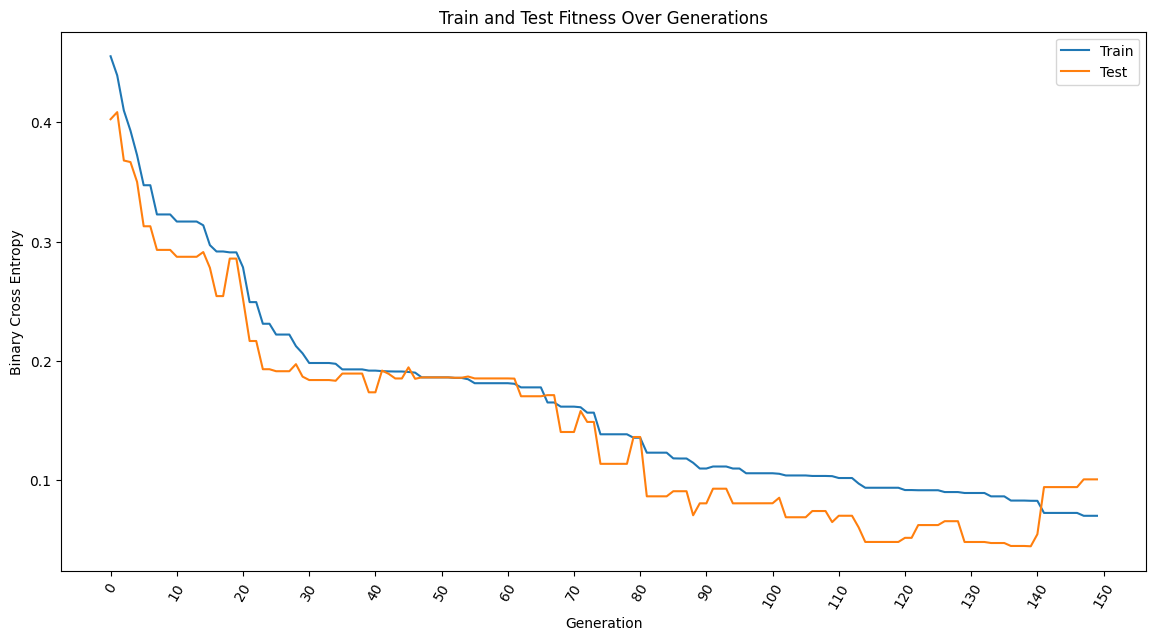

In [19]:
plt.figure(figsize=(14, 7))
plt.title("Train and Test Fitness Over Generations")
plt.xticks(range(1, gen + 2), rotation=60)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.plot(range(len(train_scores)), train_scores, label="Train")
plt.plot(range(len(test_scores)), test_scores, label="Test")
plt.xlabel("Generation")
plt.ylabel("Binary Cross Entropy")
plt.legend()
plt.show()

## 4.6 Train/Test accuracy over generations

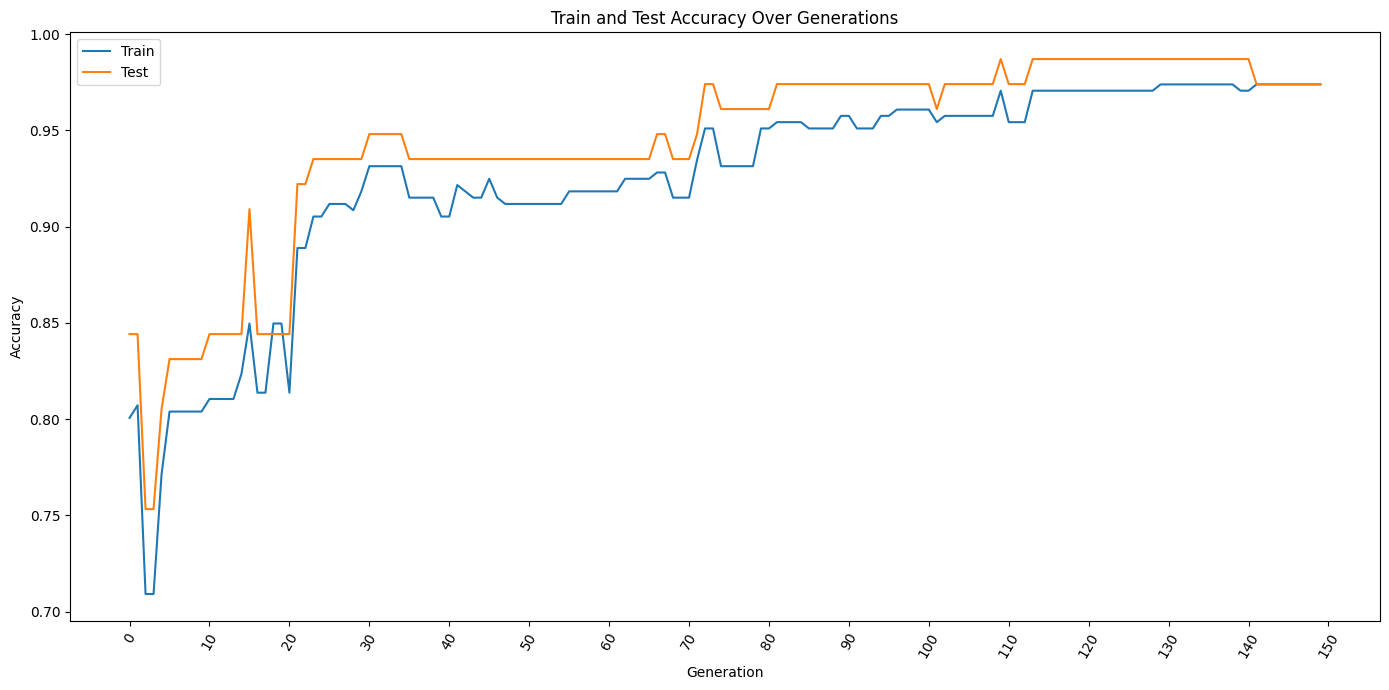

In [20]:
plt.figure(figsize=(14, 7))
plt.title("Train and Test Accuracy Over Generations")
plt.xticks(range(1, gen + 2), rotation=60)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train")
plt.plot(range(len(test_accuracies)),test_accuracies, label="Test")
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## 4.7 Best Individual in final population

In [21]:
best_individual = best_individuals[-1]
print("Best:", best_individual)

predict_train = predict(individual=best_individual, arg_x=X_train.to_numpy())
predict_train_proba = to_proba(predict_train)
predict_train_class = to_class(predict_train_proba)
bce_train = bce(y_train, predict_train_proba)
accuracy_train = accuracy_score(y_train, predict_train_class)
print(f"Train: bce: {bce_train}, accuracy: {accuracy_train}")

predict_test = predict(individual=best_individual, arg_x=X_test.to_numpy())
predict_test_proba = to_proba(predict_test)
predict_test_class = to_class(predict_test_proba)
bce_test = bce(y_test, predict_test_proba)
accuracy_test = accuracy_score(y_test, predict_test_class)
print(f"Test: bce: {bce_test}, accuracy: {accuracy_test}")

print("Classification Report:\n", classification_report(y_test, predict_test_class))

Best: sub(add(add(add(sin(neg(Response)), add(sin(neg(Response)), Stage)), add(Thyroid_Function_Euthyroid, if_zero(Stage, Gender_M, Thyroid_Function_Euthyroid))), add(add(sin(neg(Response)), add(sin(neg(Response)), if_pos(T_T1b, add(Response, Response), Focality_Uni_Focal))), sin(if_zero(Stage, Gender_M, Thyroid_Function_Euthyroid)))), add(sub(add(sub(div(Response, Response), Response), add(Risk_Low, div(Response, Response))), Response), add(mul(add(Thyroid_Function_Euthyroid, Adenopathy_No), add(sub(div(Response, Response), Response), add(N_N0, div(Risk_Low, Response)))), div(div(add(Response, Response), cos(Pathology_Hurthel_cell)), Response))))
Train: bce: 0.0701900128909483, accuracy: 0.9738562091503268
Test: bce: 0.10071923455499093, accuracy: 0.974025974025974
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        58
           1       0.95      0.95      0.95        19

    accuracy                       

# 5. Report

## 5.0 imports

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from deap.gp import graph
import pygraphviz as pgv
from IPython.display import Image, display

%matplotlib inline

## 5.1 Confusion Matrix

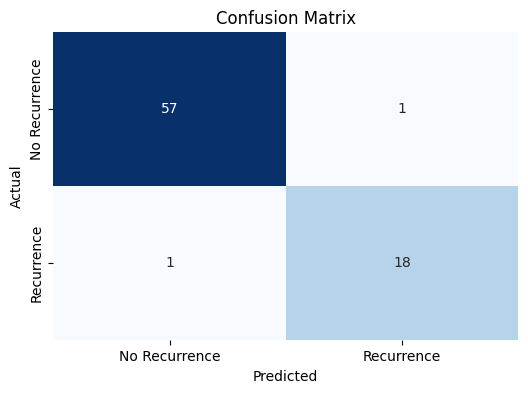

In [23]:
cm = confusion_matrix(y_test, predict_test_class)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["No Recurrence", "Recurrence"],
    yticklabels=["No Recurrence", "Recurrence"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 5.2 Feature Importance

### 5.2.0 Utilities for print/plot feature importance

In [24]:
def create_feature_importance_df(feature_importance):
    df = pd.DataFrame(
        {
            "Feature": [v[0] for v in feature_importance],
            "Importance": [v[1] for v in feature_importance],
        }
    )
    df = df.drop(df[df["Importance"] <= 0].index)
    df = df.sort_values(by="Importance", ascending=False).reset_index(drop=True)
    return df


def print_feature_importance(feature_importance, by):
    print(f"Feature Importance by {by}:")
    df = create_feature_importance_df(feature_importance)
    print(df)


def plot_feature_importance(feature_importance, by):
    df = create_feature_importance_df(feature_importance)
    plt.figure(figsize=(12, 2 + len(feature_importance) * 0.1))
    sns.barplot(x="Importance", y="Feature", data=df)
    plt.title(f"Feature Importances by {by}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

### 5.2.1 Feature Importance based on Usage Count

#### 5.2.1.0 Feature Importance based on Usage Count: *Compute*

In [25]:
def feature_importance_by_usage_count(individual):
    """
    Counts how often each feature is used in the individual's tree.
    """
    feature_counts = dict()
    stack = [individual]

    while stack:
        node = stack.pop()
        if isinstance(node, list):  # Subtree
            stack.extend(node)
        else:
            if isinstance(node, gp.Terminal):
                node_name = node.format()
                if node_name in X.columns:
                    if node_name not in feature_counts:
                        feature_counts[node_name] = 0
                    feature_counts[node_name] += 1

    # Normalize counts to get relative importance
    total_usage = sum(feature_counts.values())
    if total_usage > 0:
        feature_importances = {
            feature: count / total_usage for feature, count in feature_counts.items()
        }
    else:
        feature_importances = dict()
    feature_importances = [(k, v) for k, v in feature_importances.items()]
    feature_importances.sort(key=lambda item: item[1], reverse=True)
    return feature_importances


feature_importance_buc = feature_importance_by_usage_count(best_individual)
print_feature_importance(feature_importance_buc, "Usage Count")

Feature Importance by Usage Count:
                      Feature  Importance
0                    Response    0.542857
1  Thyroid_Function_Euthyroid    0.114286
2                       Stage    0.085714
3                    Risk_Low    0.057143
4                    Gender_M    0.057143
5      Pathology_Hurthel_cell    0.028571
6                        N_N0    0.028571
7               Adenopathy_No    0.028571
8          Focality_Uni_Focal    0.028571
9                       T_T1b    0.028571


#### 5.2.1.1 Feature Importance based on Usage Count: *Plot*

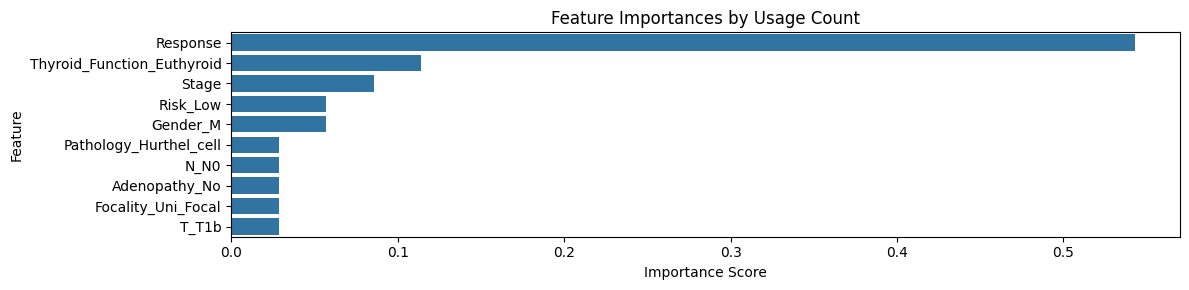

In [26]:
plot_feature_importance(feature_importance_buc, "Usage Count")

### 5.2.2 Feature Importance via Perturbation Analysis 

#### 5.2.2.0 Feature Importance via Perturbation Analysis: *Compute*

In [27]:
def feature_importance_by_perturbation(individual, arg_x, arg_y):
    """
    Computes feature importance by perturbing each feature.
    """
    baseline_score = fitfunc(individual, arg_x, arg_y)[0]
    feature_importances = {}

    for i in range(arg_x.shape[1]):
        X_perturbed = arg_x.copy()
        np.random.shuffle(X_perturbed[:, i])  # Perturb the i-th feature
        perturbed_score = fitfunc(individual, X_perturbed, arg_y)[0]
        v = abs(baseline_score - perturbed_score)
        if v > 0:
            feature_importances[f"{X.columns[i]}"] = v

    # Normalize importance
    total_importance = sum(feature_importances.values())
    if total_importance > 0:
        feature_importances = {
            k: v / total_importance for k, v in feature_importances.items()
        }
    else:
        feature_importances = dict()

    feature_importances = [(k, v) for k, v in feature_importances.items()]
    feature_importances.sort(key=lambda item: item[1], reverse=True)
    return feature_importances


feature_importance_bp = feature_importance_by_perturbation(
    best_individual,
    arg_x=X_train.to_numpy(),
    arg_y=y_train.to_numpy(),
)
print_feature_importance(feature_importance_bp, "Perturbation")

Feature Importance by Perturbation:
                      Feature  Importance
0                    Response    0.894772
1  Thyroid_Function_Euthyroid    0.018289
2                       Stage    0.017266
3                    Risk_Low    0.015991
4                        N_N0    0.014950
5                       T_T1b    0.013122
6                    Gender_M    0.008203
7               Adenopathy_No    0.007780
8          Focality_Uni_Focal    0.005042
9      Pathology_Hurthel_cell    0.004585


#### 5.2.2.1 Feature Importance via Perturbation Analysis: *Plot*

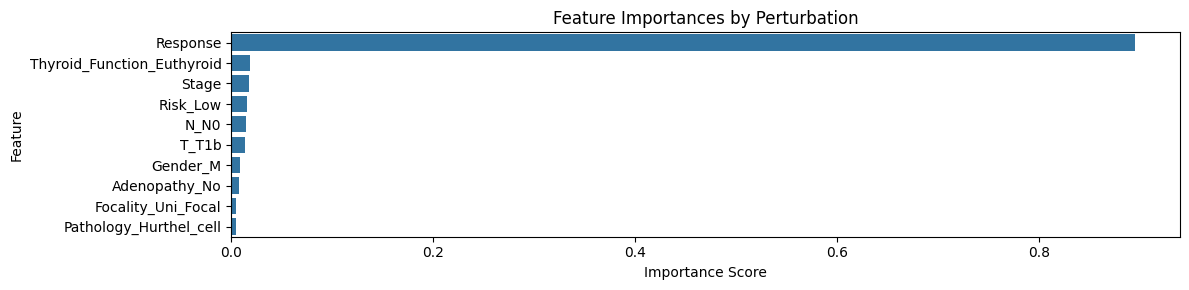

In [28]:
plot_feature_importance(feature_importance_bp, "Perturbation")

## 5.3 Plot the best individual as a directed graph

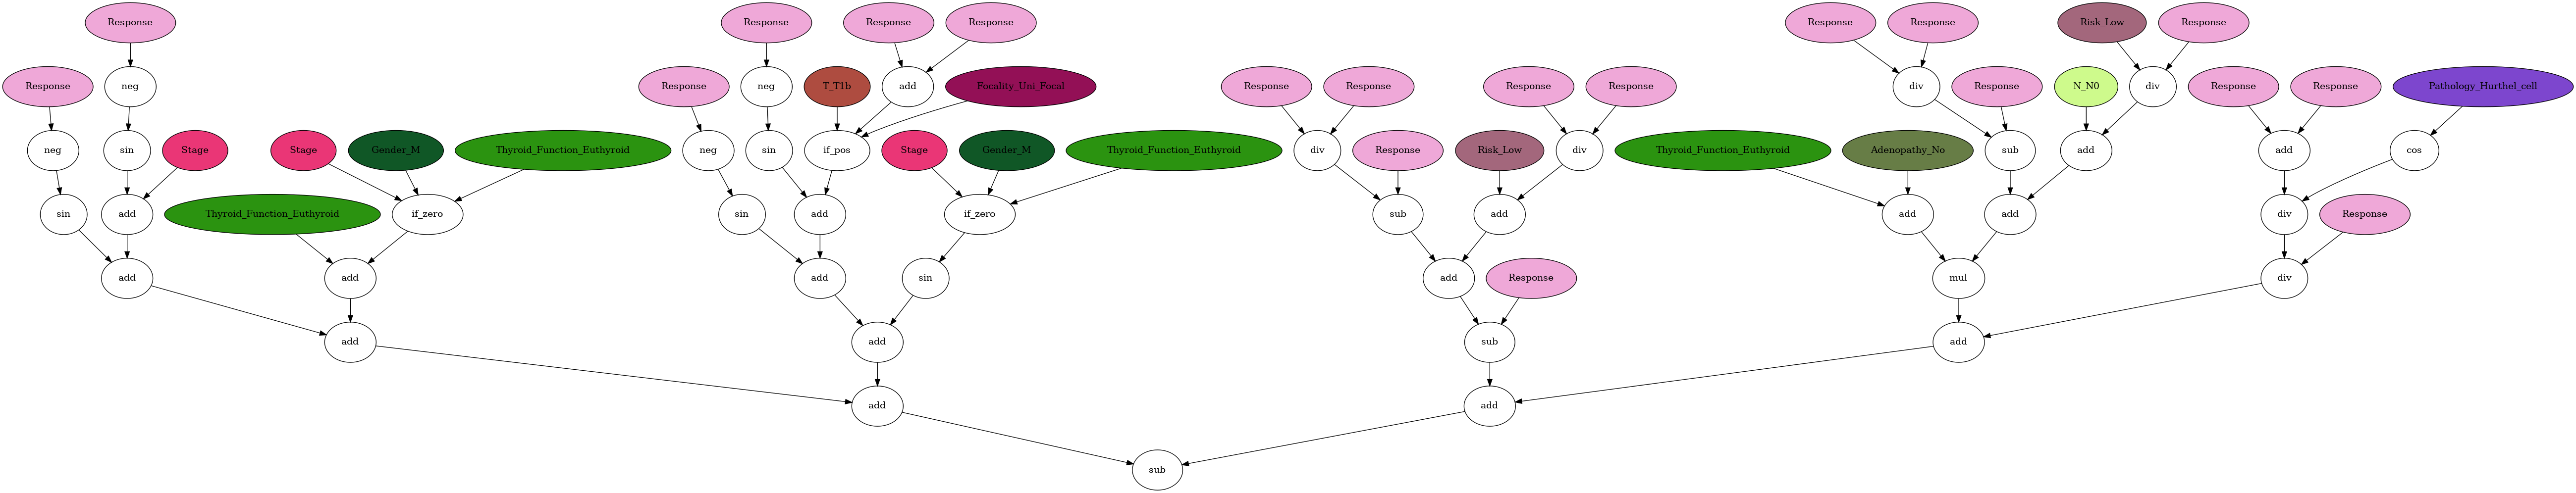

In [29]:
nodes, edges, labels = graph(best_individual)


# Create a graph
G = pgv.AGraph(directed=True)
G.graph_attr["rankdir"] = "TB"

# Add nodes with custom attributes
columns = list(X.columns)
terminal_color_set = 0xFFFFFF
terminal_color_step = terminal_color_set // (len(columns) + 1)
for n in nodes:
    label = labels[n]
    if label in columns:
        idx = columns.index(label)
        G.add_node(
            n,
            label=label,
            margin=0.2,
            fillcolor=f"#{terminal_color_step*(idx+1):06x}",
            style="filled",
        )
    elif isinstance(label, int) or isinstance(label, float) or label.isnumeric():
        G.add_node(n, label=label, margin=0.2, color="red")
    else:
        G.add_node(n, label=label, margin=0.2)

# Add edges
for edge in edges:
    G.add_edge(*(edge[::-1]))

G.layout(prog="dot")
png_data = G.draw(format="png")
display(Image(png_data))

# 6. Summary

In [30]:
print(f"Best Individual Expression:\n{best_individual}")
print()
print(f"Train Set Accuracy: {accuracy_train*100:.1f}%")
print(f"Test Set Accuracy: {accuracy_test*100:.1f}%")
print()
print("Classification Report:\n", classification_report(y_test, predict_test_class))
print()
print_feature_importance(feature_importance_buc, "Usage Count")
print()
print_feature_importance(feature_importance_bp, "Perturbation")

Best Individual Expression:
sub(add(add(add(sin(neg(Response)), add(sin(neg(Response)), Stage)), add(Thyroid_Function_Euthyroid, if_zero(Stage, Gender_M, Thyroid_Function_Euthyroid))), add(add(sin(neg(Response)), add(sin(neg(Response)), if_pos(T_T1b, add(Response, Response), Focality_Uni_Focal))), sin(if_zero(Stage, Gender_M, Thyroid_Function_Euthyroid)))), add(sub(add(sub(div(Response, Response), Response), add(Risk_Low, div(Response, Response))), Response), add(mul(add(Thyroid_Function_Euthyroid, Adenopathy_No), add(sub(div(Response, Response), Response), add(N_N0, div(Risk_Low, Response)))), div(div(add(Response, Response), cos(Pathology_Hurthel_cell)), Response))))

Train Set Accuracy: 97.4%
Test Set Accuracy: 97.4%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        58
           1       0.95      0.95      0.95        19

    accuracy                           0.97        77
   macro avg       0.97    